In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import torch, time, wandb, os, ssl
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random

In [3]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, height=1000, width=8, output_units=10, conv_layers_config=None,
                 num_fc_layers=2, hidden_units=128, kernel_size=(3, 3), pool_size=(2, 2), nonlin=nn.ReLU,
                 dropout_rate=0.2, stride=1, padding=2):
        super(CNN, self).__init__()

        if conv_layers_config is None:
            conv_layers_config = [16, 64, 16]
        self.conv_layers_config = conv_layers_config
        self.num_fc_layers = num_fc_layers
        self.conv_layers = nn.ModuleList()
        current_channels = input_channels
        for out_channels in conv_layers_config:
            self.conv_layers.append(nn.Conv2d(current_channels, out_channels, kernel_size, stride=stride, padding=padding))
            self.conv_layers.append(nn.BatchNorm2d(out_channels))
            self.conv_layers.append(nonlin())
            self.conv_layers.append(nn.MaxPool2d(pool_size))
            self.conv_layers.append(nn.Dropout(dropout_rate))
            current_channels = out_channels
        self.num_features = self._calculate_num_features(input_channels, height, width)

        self.fc_layers = nn.ModuleList()
        current_units = self.num_features
        for i in range(num_fc_layers - 1):
            self.fc_layers.append(nn.Linear(current_units, hidden_units))
            self.fc_layers.append(nonlin())
            self.fc_layers.append(nn.Dropout(dropout_rate))
            current_units = hidden_units
        self.fc_layers.append(nn.Linear(current_units, output_units))  # Fixed this line

    def _calculate_num_features(self, channels, height, width):
        with torch.no_grad():
            x = torch.zeros(1, channels, height, width)
            for layer in self.conv_layers:
                x = layer(x)
            return x.numel()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        for layer in self.fc_layers:
            x = layer(x)
        return x

In [4]:
class Trainer:
    def __init__(self, model, device, train_loader, val_loader, optimizer, scheduler, criterion):
        # Initialize the Trainer class with model, device, data loaders, optimizer, scheduler, and loss function
        self.model = model  # Neural network model to be trained and validated
        self.device = device  # Device on which the model will be trained (e.g., 'cuda' or 'cpu')
        self.train_loader = train_loader  # DataLoader for the training dataset
        self.val_loader = val_loader  # DataLoader for the validation dataset
        self.optimizer = optimizer  # Optimizer for adjusting model parameters
        self.scheduler = scheduler  # Learning rate scheduler for the optimizer
        self.criterion = criterion  # Loss function to measure model performance

    def train_epoch(self):
        # Train the model for one epoch and return the average loss and accuracy
        self.model.train()  # Set the model to training mode
        total_loss, total_accuracy = 0, 0  # Initialize accumulators for loss and accuracy
        for images, labels in self.train_loader:
            # Reshape images and move images and labels to the specified device
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()  # Clear previous gradients
            output = self.model(images)  # Forward pass through the model
            loss = self.criterion(output, labels)  # Compute loss between model output and true labels
            loss.backward()  # Backpropagate the loss to compute gradients
            self.optimizer.step()  # Update model parameters
            # Calculate accuracy by comparing predicted and true labels
            accuracy = (output.argmax(dim=1) == labels).float().mean().item()
            # Accumulate total loss and accuracy
            total_loss += loss.item()
            total_accuracy += accuracy
        # Return average loss and accuracy for the epoch
        return total_loss / len(self.train_loader), total_accuracy / len(self.train_loader)

    def validate_epoch(self):
        # Validate the model for one epoch and return the average loss, accuracy, precision, recall, and F1 score
        self.model.eval()  # Set the model to evaluation mode
        val_loss, val_accuracy = 0, 0  # Initialize accumulators for validation loss and accuracy
        all_preds = []  # List to store all predictions
        all_labels = []  # List to store all true labels
        with torch.no_grad():  # Disable gradient computation
            for images, labels in self.val_loader:
                # Reshape images and move images and labels to the specified device
                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)  # Forward pass through the model
                # Accumulate validation loss and accuracy
                val_loss += self.criterion(output, labels).item()
                val_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
                all_preds.extend(output.argmax(dim=1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
        cm = confusion_matrix(all_labels, all_preds)
        # Calculate precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds, average='weighted',zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Return average validation loss, accuracy, precision, recall, F1, and confusion matrix for the epoch
        return (val_loss / len(self.val_loader), 
                val_accuracy / len(self.val_loader), 
                precision, 
                recall, 
                f1, 
                cm)
    
    def fit(self, epochs):
        # Train and validate the model over multiple epochs
        train_accuracies, val_accuracies = [], []  # Lists to store accuracies for each epoch
        pbar = tqdm(range(epochs), desc="Epoch Progress")  # Progress bar to track training progress
        for epoch in pbar:
            # Train and validate for one epoch
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy, precision, recall, f1, cm = self.validate_epoch()
    
            # Log metrics to Weights & Biases, including the confusion matrix as an image
            wandb.log({
                "Train Loss": train_loss,
                "Train Accuracy": train_accuracy,
                "Validation Loss": val_loss,
                "Validation Accuracy": val_accuracy*100,
                "Validation Precision": precision*100,
                "Validation Recall": recall*100,
                "Validation F1 Score": f1*100,
                "Confusion Matrix": wandb.Image(cm)  # Log the confusion matrix as an image
            })
            # Update progress bar with current epoch loss and accuracy
            pbar.set_description(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_accuracy:.2f} | Val Precision: {precision:.2f} | Val Recall: {recall:.2f} | Val F1: {f1:.2f}")
            self.scheduler.step()  # Update learning rate based on the scheduler
            
            # Store train and validation accuracies
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
        Performance_metrics = [val_accuracy*100,precision*100,recall*100,f1*100]
        return train_accuracies, val_accuracies, Performance_metrics, cm  # Return confusion matrix as well

In [5]:
def plot_confusion_matrix(cm, class_names, file_name=None):
    plt.figure(figsize=(9, 9))  # Set size appropriate for IEEE papers
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis_r',  # Use 'Greys' but can add options like 'viridis', for color
                xticklabels=class_names, yticklabels=class_names, 
                cbar=False)  # Disable color bar for a simpler look
    
    # Setting titles and labels with appropriate size
    plt.title('Confusion Matrix', fontsize=10)
    plt.xlabel('Predicted Labels', fontsize=10)
    plt.ylabel('True Labels', fontsize=10)
    
    # Ticks customization 
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Tight layout for better space management
    plt.tight_layout()
    
    # If a file name is provided, save the figure
    if file_name:
        plt.savefig(file_name, dpi=300, bbox_inches='tight', format='png')  # Specify the format as needed
    plt.show()

def awgn(sig, req_snr, sig_power='measured', random_state=None, power_type='db'):
    sig = np.asarray(sig)
    if sig_power == 'measured':
        sig_power = np.mean(np.abs(sig) ** 2)
    if power_type == 'db':
        sig_power = 10 ** (sig_power / 10)
        req_snr = 10 ** (np.asarray(req_snr) / 10)
    noise_power = sig_power / req_snr
    if random_state is not None:
        np.random.seed(random_state)
    noise = np.sqrt(noise_power) * np.random.randn(*sig.shape)
    noisy_signal = sig + noise
    return noisy_signal, noise_power

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
def train_and_validate(epochs=15, batch_size=64, lr=1e-4, test_size=0.2, Oscillation_mechanism_flag = "01", noisy_flag = True, desired_snr_db = 40, plot_confusion = True):
    # Fixing SSL error 
    ssl._create_default_https_context = ssl._create_unverified_context

    # Define the model type and other relevant information
    model_type = "CNN"
    # Format the name by combining the model type with the timestamp
    run_name = f"{model_type}_{time.strftime('%Y%m%d%H%M%S')}"
    # Initialize the W&B run with the combined name
    # wandb.init(project="OS_location_CNN", name=run_name)
    wandb.init(mode="offline")
    # wandb.init(mode="online")
    # Function to train, validate, quantize the model, and evaluate the quantized model
    random_seed = 29
    set_seed(random_seed)
    # Negative resistance mechanism
    npz_path1 = r"Datasets\Dataset_1.npz"
    data111 = np.load(npz_path1)
    # Define 'X' and 'y' are the dataset features and labels
    X1 = data111["X_data"]
    y1 = data111["Y_data"].flatten()
    y1 = data111["Y_data"].flatten()
    y_classnums = np.unique(y1).size
    X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=test_size, random_state=random_seed)
    if noisy_flag == True:
        X_val, _ = awgn(X_val, desired_snr_db)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).long()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).long()
    trainset1 = TensorDataset(X_train, y_train)
    valset1 = TensorDataset(X_val, y_val)
    trainloader1 = DataLoader(trainset1, batch_size=batch_size, shuffle=True)
    valloader1 = DataLoader(valset1, batch_size=batch_size, shuffle=False)
    # Modal resonance mechanism
    npz_path2 = r"Datasets\Dataset_2.npz"
    data222 = np.load(npz_path2)
    X2 = data222["X_data"]
    y2 = data222["Y_data"].flatten()
    y_classnums = np.unique(y2).size
    X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=test_size, random_state=random_seed)
    if noisy_flag == True:
        X_val, _ = awgn(X_val, desired_snr_db)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).long()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).long()
    trainset2 = TensorDataset(X_train, y_train)
    valset2 = TensorDataset(X_val, y_val)
    trainloader2 = DataLoader(trainset2, batch_size=batch_size, shuffle=True)
    valloader2 = DataLoader(valset2, batch_size=batch_size, shuffle=False)
    # Both mechanisms
    npz_path = r"Datasets\Dataset_1and_2.npz"
    data = np.load(npz_path)
    X = data["X_data"]
    y = data["Y_data"].flatten()
    y_classnums = np.unique(y).size
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_seed)
    if noisy_flag == True:
        X_val, _ = awgn(X_val, desired_snr_db)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).long()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).long()
    trainset = TensorDataset(X_train, y_train)
    valset = TensorDataset(X_val, y_val)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

    # Initialize the CNN model with specified layer sizes
    conv_layers_config = [16, 64, 128, 64, 16]
    model = CNN(input_channels=1, height=20, width=120, output_units=y_classnums, conv_layers_config=conv_layers_config,
                 num_fc_layers=2, hidden_units=128, kernel_size=(3, 3), pool_size=(2, 2), nonlin=nn.ReLU,
                 dropout_rate=0.2, stride=1, padding=2)
    # Determine the appropriate device based on GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the selected device
    # model = torch.compile(model)

    # Set up the optimizer with specified parameters
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # Define the learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Set the loss function for training and validation
    criterion = nn.CrossEntropyLoss()

    # Initialize the Trainer and train the model
    if Oscillation_mechanism_flag == "12":
        trainer = Trainer(model, device, trainloader1, valloader2, optimizer, scheduler, criterion)
    elif Oscillation_mechanism_flag == "21":
        trainer = Trainer(model, device, trainloader2, valloader1, optimizer, scheduler, criterion)
    elif Oscillation_mechanism_flag == "11":
        trainer = Trainer(model, device, trainloader1, valloader1, optimizer, scheduler, criterion)
    elif Oscillation_mechanism_flag == "22":
        trainer = Trainer(model, device, trainloader2, valloader2, optimizer, scheduler, criterion)
    elif Oscillation_mechanism_flag == "all":
        trainer = Trainer(model, device, trainloader, valloader, optimizer, scheduler, criterion)
    elif Oscillation_mechanism_flag == "all1":
        trainer = Trainer(model, device, trainloader, valloader1, optimizer, scheduler, criterion)
    elif Oscillation_mechanism_flag == "all2":
        trainer = Trainer(model, device, trainloader, valloader2, optimizer, scheduler, criterion)    
    else:
        warnings.warn("Oscillation_mechanism_flag does not match any expected value, Please enter appropriate values, such as 12, 21, 11, 22, all, all1, all2!")
        
    train_accuracies, val_accuracies, Performance_metrics, cm = trainer.fit(epochs)
    
    # Ensure the directory for saving models exists
    model_save_dir = "./models"
    os.makedirs(model_save_dir, exist_ok=True)

    # Save the trained model's state dictionary
    torch.save(model.state_dict(), os.path.join(model_save_dir, "CNN_model.pth"))

    # Evaluate the time taken to evaluate the original model
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for images, labels in valloader1:
            # Reshape images and move them and labels to the selected device
            images, labels = images.to(device), labels.to(device)
            output = model(images)
    original_time = time.time() - start_time  # Calculate the total evaluation time

    # Print the results summary
    print(f"CNN Model Evaluation Time: {original_time:.4f} seconds")
    # print(f"Train Accuracies: {train_accuracies}")
    # print(f"Validation Accuracies: {val_accuracies}")
    if plot_confusion == True:
        class_names = [f'Label {i}' for i in range(y_classnums)]
        fig_save_dir = "./confusion_matrix"
        file_name = os.path.join(fig_save_dir, "CNN_confusion_matrix"+"_"+str(Oscillation_mechanism_flag)+".png")
        file_name = None
        plot_confusion_matrix(cm, class_names, file_name)
    
    wandb.finish()  # Finalize the Weights & Biases run
    return Performance_metrics

Evaluate the model under the same oscillation mechanisms

Epoch 50 | Train Loss: 0.0100 | Val Accuracy: 0.99 | Val Precision: 0.99 | Val Recall: 0.99 | Val F1: 0.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.33it/s]


CNN Model Evaluation Time: 0.0339 seconds


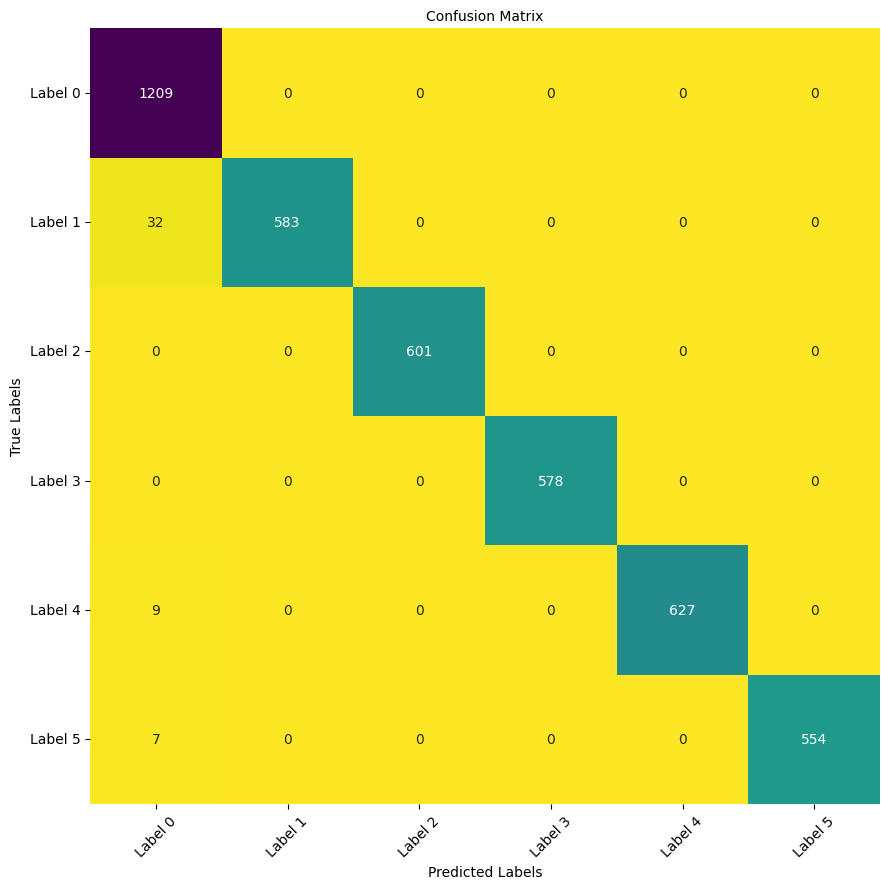

Train Accuracy,▁▂▅▇████████████████████████████████████
Train Loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▄▆▇▇▇█████████████████████████████████
Validation F1 Score,▁▂▄▇▇███████████████████████████████████
Validation Loss,██▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Precision,▁▄▆▇▇███████████████████████████████████
Validation Recall,▁▂▄▆▇▇▇█████████████████████████████████
Train Accuracy,0.99909
Train Loss,0.01005
Validation Accuracy,98.84725
Validation F1 Score,98.8568


In [8]:
# Call the function to train and evaluate the model
performance_metrics = train_and_validate(
                   epochs=50, 
                   batch_size=128,
                   lr=1e-4,
                   test_size=0.3, 
                   Oscillation_mechanism_flag = "11",
                   noisy_flag = True,
                   desired_snr_db = np.random.randint(20, 40),
                   plot_confusion = True)

Evaluate the model under the different oscillation mechanisms

Epoch 50 | Train Loss: 0.0100 | Val Accuracy: 0.34 | Val Precision: 0.52 | Val Recall: 0.34 | Val F1: 0.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.34it/s]


CNN Model Evaluation Time: 0.0355 seconds


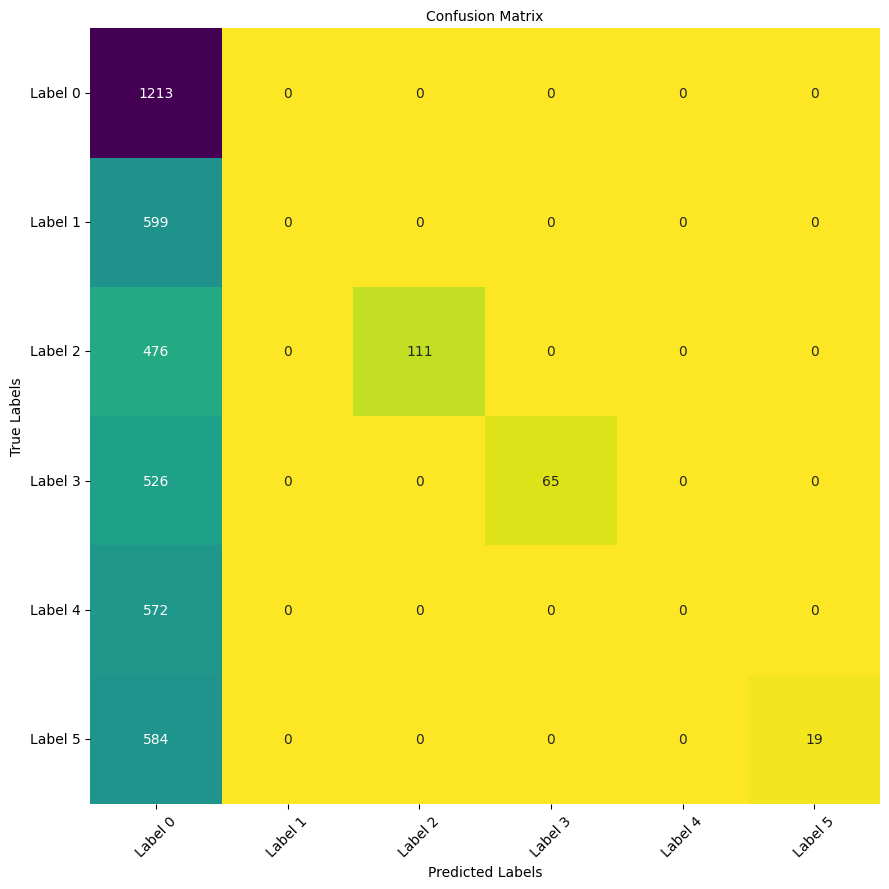

Train Accuracy,▁▂▅▇████████████████████████████████████
Train Loss,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▂▁▁▂▃▃▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇▇▇██▇▇█▇█
Validation F1 Score,▆▂▁▁▂▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇▇▇██▇▇█▇█
Validation Loss,▁▂▄▄▆▆▇▇▇▇▇██▇████▇█████████████████████
Validation Precision,▂▄▁▃▃▅▃▇▆▆▆█████████████████████████████
Validation Recall,▇▂▁▁▂▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇▇▇██▇▇█▇█
Train Accuracy,0.99909
Train Loss,0.01005
Validation Accuracy,33.71795
Validation F1 Score,21.81085


In [10]:
# Call the function to train and evaluate the model 
performance_metrics = train_and_validate(
                   epochs=50, 
                   batch_size=128, 
                   lr=1e-4,
                   test_size=0.3, 
                   Oscillation_mechanism_flag = "12",
                   noisy_flag = True,
                   desired_snr_db = np.random.randint(20, 40),
                   plot_confusion = True)

Evaluate the model based on training with data aggregated from both oscillation mechanisms

Epoch 50 | Train Loss: 0.0022 | Val Accuracy: 0.99 | Val Precision: 0.99 | Val Recall: 0.99 | Val F1: 0.99: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


CNN Model Evaluation Time: 0.0474 seconds


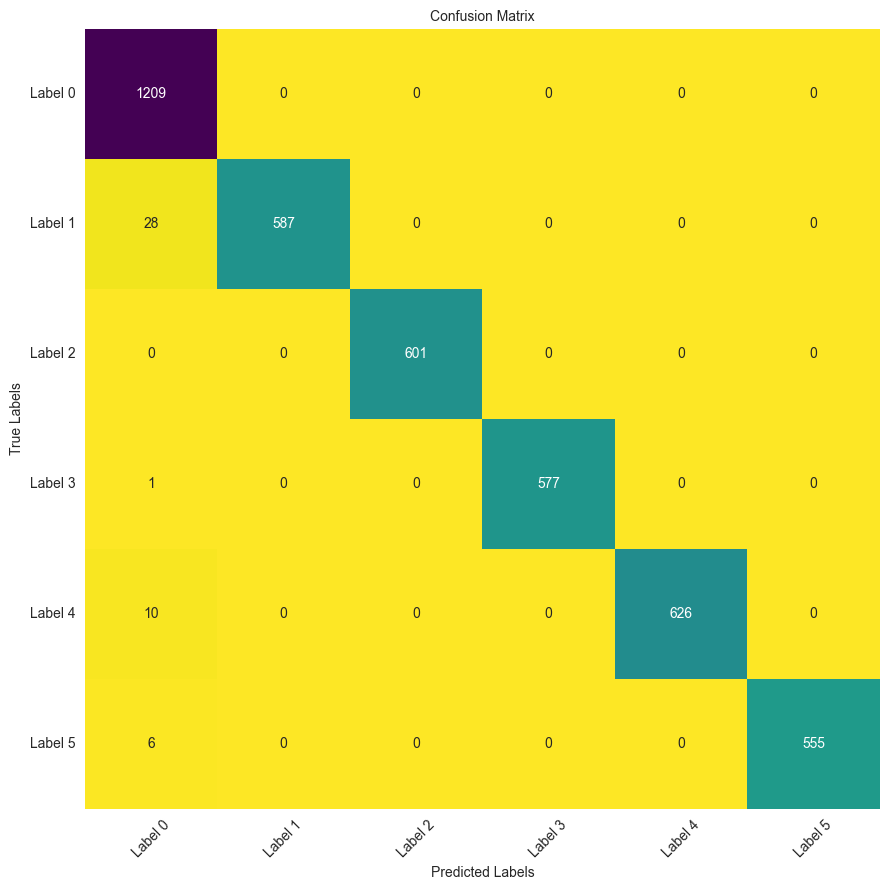

Train Accuracy,▁▄▇█████████████████████████████████████
Train Loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇▇██████████████████████████████████
Validation F1 Score,▁▄▇▇▇███████████████████████████████████
Validation Loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Precision,▁▅▇▇████████████████████████████████████
Validation Recall,▁▄▆▇▇▇██████████████████████████████████
Train Accuracy,0.99964
Train Loss,0.00222
Validation Accuracy,98.91827
Validation F1 Score,98.92926


In [8]:
# Call the function to train and evaluate the model
performance_metrics = train_and_validate(
                   epochs=50, 
                   batch_size=128, 
                   lr=1e-4,
                   test_size=0.3, 
                   Oscillation_mechanism_flag = "all1",
                   noisy_flag = True,
                   desired_snr_db = np.random.randint(20, 40),
                   plot_confusion = True)

References related to the open-loop modal resonance mechanism and the negative resistance mechanism are as follows:

[1] W. Du, J. Chen, Y. Wang, and H. F. Wang, 
"Measurement-driven source tracing of torsional subsynchronous oscillations caused by open-loop modal resonance," 
*IEEE Transactions on Instrumentation and Measurement*, vol. 71, pp. 1–14, 2022.

[2] W. Du, X. Chen, and H. Wang, 
"A method of open-loop modal analysis to examine the SSOs in a multi-machine power system with multiple variable-speed wind generators," 
*IEEE Transactions on Power Systems*, vol. 33, no. 4, pp. 4297–4307, 2017.

[3] H. Liu, X. Xie, J. He, T. Xu, Z. Yu, C. Wang, and C. Zhang, 
"Subsynchronous interaction between direct-drive PMSG based wind farms and weak AC networks," 
*IEEE Transactions on Power Systems*, vol. 32, no. 6, pp. 4708–4720, 2017.

[4] H. Liu, X. Xie, C. Zhang, Y. Li, H. Liu, and Y. Hu, “Quantitative SSR analysis of series-compensated DFIG-based wind farms using aggregated RLC circuit model,” *IEEE Transactions on Power Systems*, vol. 32, no. 1, pp. 474–483, Jan. 2016.